In [1]:
import json
from pathlib import Path

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pickle
import torch
from torch import nn
import numpy as np
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset

from sklearn.svm import SVC
import joblib

import gensim.downloader as api

from sklearn.preprocessing import OneHotEncoder

/users/eleves-b/2021/timothee.vincon/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

path_to_training = Path("../data/training")
path_to_test = Path("../data/test")

In [3]:
test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])

training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')

In [4]:
bert = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
y_training = []
with open("../data/training_labels.json", "r") as file:
    training_labels = json.load(file)
X_training = [] 
X_training_edges = []
X_training_speaker = []

In [6]:
edge_types = ['Continuation', 'Explanation', 'Elaboration', 'Acknowledgement', 'Comment', 'Result', 'Question-answer_pair', 'Contrast', 'Clarification_question', 'Background', 'Narration', 'Alternation', 'Conditional', 'Q-Elab', 'Correction', 'Parallel']
speakers = ['PM', 'ME', 'UI', 'ID']

encoder_edge = OneHotEncoder(handle_unknown='ignore')
encoder_edge.fit(np.array(edge_types).reshape(-1, 1))

encoder_speaker = OneHotEncoder(handle_unknown='ignore')
encoder_speaker.fit(np.array(speakers).reshape(-1, 1))

print(encoder_edge.transform(np.array(['Explanation']).reshape(-1,1)).toarray().squeeze())
print(encoder_speaker.transform(np.array(['ME']).reshape(-1,1)).toarray().squeeze())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0.]


In [7]:
for transcription_id in training_set:
    
    file_path = "../data/training/" + transcription_id + '.txt'

    with open(file_path, 'r') as file:

        edge_type_transcriptionId = []

        for line in file:

            # Split the line in words
            words = line.split()

            # If the line is not empty
            if words:
                edge_type_transcriptionId.append(words[1])    # Type of the edge
                if words[1] not in edge_types:
                    edge_types.append(words[1])
            else:
                print("line is empty")
    
    with open(path_to_training / f"{transcription_id}.json", "r") as file:
        transcription = json.load(file)

    X_training_text_current = []

    c = 0
    for utterance in transcription:
        speaker = encoder_speaker.transform(np.array([utterance["speaker"]]).reshape(-1,1)).toarray().squeeze()
        
        X_training_speaker.append(speaker)


        if(c == 0):
            X_training.append(utterance["text"])
            X_training_edges.append(np.array([0.0]*len(edge_types)))
            X_training_text_current.append(utterance["text"])
        else:
            X_training.append(utterance["text"])
            edge = encoder_edge.transform(np.array([edge_type_transcriptionId[c-1]]).reshape(-1,1)).toarray().squeeze()
            X_training_edges.append(edge)
            X_training_text_current.append(utterance["text"])
        c+=1

    y_training += training_labels[transcription_id]

In [8]:
print("start encoding") 

X_training = bert.encode(X_training, show_progress_bar=True)

start encoding


Batches: 100%|██████████| 2270/2270 [00:14<00:00, 156.06it/s]


In [9]:
X_training_edges = np.array(X_training_edges)
X_training_speaker = np.array(X_training_speaker)

print(X_training.shape)
print(X_training_edges.shape)
print(X_training_speaker.shape)

(72623, 384)
(72623, 16)
(72623, 4)


In [10]:
X_training_final = [np.concatenate((x, y, z)) for x, y,z in zip(X_training, X_training_speaker, X_training_edges)]
print("final premier element ", X_training_final[0].shape)
print("encoding training dataset finished")

final premier element  (404,)
encoding training dataset finished


In [11]:
# apply pca to reduce dimensionality

from sklearn.decomposition import PCA   

pca = PCA(n_components=2)

X_training_final_pca = pca.fit_transform(X_training_final)

print("pca finished")

pca finished


KeyboardInterrupt: 

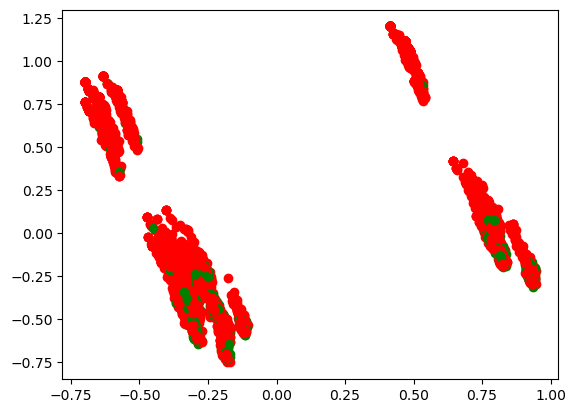

In [12]:
# plot the pca

colors = ['red', 'green']

print(len(X_training_final_pca))

for i in range(len(X_training_final_pca)):

    if i % 100 == 0:
        print('step ', i, ' / ', len(X_training_final_pca))

    plt.scatter(X_training_final_pca[i][0], X_training_final_pca[i][1], color=colors[y_training[i]])

plt.show()